In [37]:
import pandas as pd
from pathlib import Path
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import subprocess, sys
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [30]:
# 1. Load the feature matrix
PROC = Path('../data/processed')
df = pd.read_parquet(PROC / 'features.parquet')

# 2. Train/test split: GW 1–34 => train, GW 35–38 => test
train = df[df['round'] <= 34]
test  = df[df['round'] >  34]

# 3. Define X/y, dropping identifier columns
X_train = train.drop(columns=['element', 'round', 'total_points'])
y_train = train['total_points']
X_test  = test.drop(columns=['element', 'round', 'total_points'])
y_test  = test['total_points']

X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

# 4. Baseline: mean predictor
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
pred_base = baseline.predict(X_test)

mse_base = mean_squared_error(y_test, pred_base)
rmse_base = mse_base ** 0.5

print("Baseline MAE: ", mean_absolute_error(y_test, pred_base))
print("Baseline RMSE:", rmse_base)

# 5. Linear (Ridge) regression
model_lr = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = mse_lr ** 0.5

print("Ridge MAE: ", mean_absolute_error(y_test, pred_lr))
print("Ridge RMSE:", rmse_lr)

Baseline MAE:  1.5378093761190184
Baseline RMSE: 2.370635500675521
Ridge MAE:  0.7880872815694908
Ridge RMSE: 1.5162990539274652


XGBoost MAE:  0.6543
XGBoost RMSE: 1.4578

Top 10 features by XGB gain:
                    gain
feature                 
started       618.387939
form_pts4     177.866776
full_match     57.259140
price_m        44.807266
form_min4      37.561424
fixture_diff   29.452581
xA             16.598160
is_home        14.943896
xG             14.648310


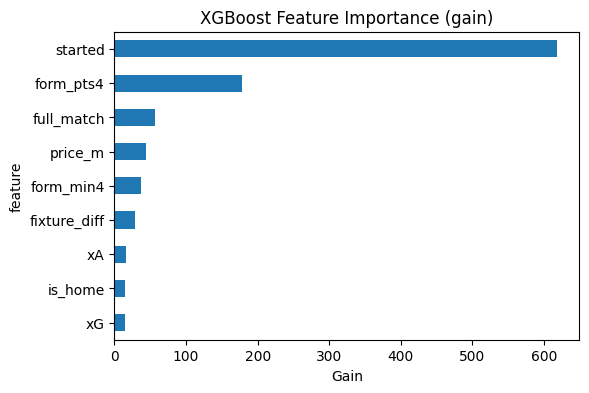

In [31]:
# 1. Load the feature matrix
PROC = Path('../data/processed')
df = pd.read_parquet(PROC / 'features.parquet')

# 2. Split: GWs 1–34 ⇒ train, 35–38 ⇒ test
train = df[df['round'] <= 34]
test  = df[df['round'] >  34]

# 3. Prepare X/y and ensure numeric types
X_train = train.drop(columns=['element','round','total_points']).copy()
y_train = train['total_points']
X_test  = test.drop(columns=['element','round','total_points']).copy()
y_test  = test['total_points']

# Convert xG/xA to float, fill NaNs with 0
for col in ['xG','xA']:
    if col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0.0)
        X_test[col]  = pd.to_numeric(X_test[col],  errors='coerce').fillna(0.0)

# Also fill any other NaNs (just in case)
X_train = X_train.fillna(0.0)
X_test  = X_test.fillna(0.0)

# 4. Instantiate and fit XGBRegressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# 5. Predictions & metrics
pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, pred_xgb)
rmse_xgb = mse_xgb ** 0.5
mae_xgb = mean_absolute_error(y_test, pred_xgb)

print(f"XGBoost MAE:  {mae_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")

# 6. Feature importances (by “gain”)
importances = xgb_model.get_booster().get_score(importance_type='gain')
fi = pd.DataFrame.from_dict(importances, orient='index', columns=['gain'])
fi.index.name = 'feature'
fi = fi.sort_values('gain', ascending=False)

print("\nTop 10 features by XGB gain:")
print(fi.head(10))

# 7. Plot the top‐10 importances
plt.figure(figsize=(6,4))
fi.head(10)['gain'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (gain)")
plt.xlabel("Gain")
plt.show()


In [36]:
import pandas as pd
from pathlib import Path

# 1. Load the full features DataFrame
df = pd.read_parquet(Path('..') / 'data' / 'processed' / 'features.parquet')

# 2. Restrict to Rounds 1–34 for CV
df_train_cv = df[df['round'] <= 34].copy()

# 3. Sort by (round, element) so our row‐order is entirely chronological
df_train_cv = df_train_cv.sort_values(['round','element']).reset_index(drop=True)

# 4. Build X, y just like before
X = df_train_cv.drop(columns=['element','round','total_points']).fillna(0)
y = df_train_cv['total_points'].copy()

# (Convert xG,xA,fixture_diff to numeric if needed)
for col in ['xG','xA','fixture_diff']:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0.0)

# 5. Define the fold‐by‐round ranges you want
fold_ranges = [
    (range(1, 10),    range(10, 19)),   # Fold 0: train 1–9, val 10–18
    (range(1, 19),    range(19, 27)),   # Fold 1: train 1–18, val 19–26
    (range(1, 27),    range(27, 35)),   # Fold 2: train 1–26, val 27–34
]

# 6. For each fold, find the row‐indices by filtering on df_train_cv['round']
for i, (train_rounds, val_rounds) in enumerate(fold_ranges):
    train_idx = df_train_cv.index[df_train_cv['round'].isin(train_rounds)].tolist()
    val_idx   = df_train_cv.index[df_train_cv['round'].isin(val_rounds)].tolist()
    
    train_rounds_list = sorted(df_train_cv.loc[train_idx, 'round'].unique())
    val_rounds_list   = sorted(df_train_cv.loc[val_idx,   'round'].unique())

    print(f"Fold {i}:")
    print(f"  Train rounds: {train_rounds_list}")
    print(f"  Val   rounds: {val_rounds_list}")
    print("  ---------------------------")


Fold 0:
  Train rounds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
  Val   rounds: [np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]
  ---------------------------
Fold 1:
  Train rounds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]
  Val   rounds: [np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26)]
  ---------------------------
Fold 2:
  Train rounds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.i

In [38]:
# 1. Build the list of (train_idx, val_idx) tuples using Option 2:
splits = []
tscv_rounds = TimeSeriesSplit(n_splits=3)
rounds = sorted(df_train_cv['round'].unique())

for train_round_idx, val_round_idx in tscv_rounds.split(rounds):
    tr_rounds = [rounds[i] for i in train_round_idx]
    va_rounds = [rounds[i] for i in val_round_idx]
    tr_idx = df_train_cv.index[df_train_cv['round'].isin(tr_rounds)].tolist()
    va_idx = df_train_cv.index[df_train_cv['round'].isin(va_rounds)].tolist()
    splits.append((tr_idx, va_idx))

# 2. Build pipeline & param grid
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb',    XGBRegressor(
                  objective='reg:squarederror',
                  random_state=42,
                  verbosity=0
              ))
])

param_grid = {
    'xgb__n_estimators':     [50, 100, 150],
    'xgb__max_depth':        [4, 6, 8],
    'xgb__learning_rate':    [0.01, 0.05, 0.1],
    'xgb__subsample':        [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}

# 3. Pass `splits` into GridSearchCV instead of cv=TimeSeriesSplit(...)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=splits,   # using our pre‐computed train/val row indices
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 4. Fit
X = df_train_cv.drop(columns=['element','round','total_points']).fillna(0)
y = df_train_cv['total_points']

# Convert xG,xA,fixture_diff to numeric
for col in ['xG','xA','fixture_diff']:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0.0)

gs.fit(X, y)

print("Best params:", gs.best_params_)
print("Best CV RMSE:", -gs.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 50, 'xgb__subsample': 0.8}
Best CV RMSE: 1.5621306498845418


In [39]:
# 1a. Reload the full features matrix
features = pd.read_parquet(Path('..') / 'data' / 'processed' / 'features.parquet')

# 1b. Split into “train_full” = rounds 1–34, “test_final” = rounds 35–38
train_full = features[features['round'] <= 34].copy()
test_final = features[features['round'] >  34].copy()

# 1c. Build X_train, y_train, X_test, y_test
X_train = train_full.drop(columns=['element','round','total_points']).fillna(0)
y_train = train_full['total_points']

X_test  = test_final.drop(columns=['element','round','total_points']).fillna(0)
y_test  = test_final['total_points']

# 1d. Make sure xG, xA, fixture_diff are numeric
for col in ['xG','xA','fixture_diff']:
    if col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0.0)
        X_test[col]  = pd.to_numeric(X_test[col],  errors='coerce').fillna(0.0)

# 1e. Re‐create the pipeline with the best hyperparameters from your GridSearch
best_params = {
    'n_estimators':     50,
    'max_depth':        4,
    'learning_rate':    0.1,
    'subsample':        0.8,
    'colsample_bytree': 1.0,
    'objective':        'reg:squarederror',
    'random_state':     42,
    'verbosity':        0
}

final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(**best_params))
])

# 1f. Fit on GW 1–34
final_model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [45]:
# 1a. Load the newly written features.parquet
features = pd.read_parquet(Path('..') / 'data' / 'processed' / 'features.parquet')

# 1b. Split into “train” (GW 1–34) and “test” (GW 35–38)
train_full = features[features['round'] <= 34].copy()
test_final = features[features['round'] > 34].copy()

X_train = train_full.drop(columns=['element','round','total_points']).fillna(0)
y_train = train_full['total_points']

X_test  = test_final.drop(columns=['element','round','total_points']).fillna(0)
y_test  = test_final['total_points']

# 1c. Ensure numeric types for xG, xA, fixture_diff if needed
for col in ['xG','xA','fixture_diff']:
    if col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0.0)
        X_test[col]  = pd.to_numeric(X_test[col],  errors='coerce').fillna(0.0)

# 1d. Fit the final pipeline on GW 1–34 using your best hyperparameters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

best_params = {
    'n_estimators':     50,
    'max_depth':        4,
    'learning_rate':    0.1,
    'subsample':        0.8,
    'colsample_bytree': 1.0,
    'objective':        'reg:squarederror',
    'random_state':     42,
    'verbosity':        0
}

final_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb',    XGBRegressor(**best_params))
])
final_pipe.fit(X_train, y_train)

# 1e. Predict on GWs 35–38 and compute MAE/RMSE
pred_final = final_pipe.predict(X_test)
mse      = mean_squared_error(y_test, pred_final)
rmse     = mse ** 0.5
mae      = mean_absolute_error(y_test, pred_final)

print(f">>> Final-model MAE on GW 35-38:  {mae:.4f}")
print(f">>> Final-model RMSE on GW 35-38: {rmse:.4f}")

# Suppose `final_pipe` is your fitted Pipeline(['scaler', XGBRegressor]) 
xgb_step = final_pipe.named_steps['xgb']

# This array is in the same order as X_train.columns
imp_array = xgb_step.feature_importances_

# Build a DataFrame that zips each column name to its importance
fi = pd.DataFrame({
    'feature': X_train.columns,
    'gain':    imp_array
}).sort_values('gain', ascending=False)

print("Top 10 features by XGB feature_importances_:")
print(fi.head(10))

#residuals = pred_final - y_test

# 2.2a. Residual vs. fixture_diff
#plt.scatter(X_test['fixture_diff'], residuals, alpha=0.3)
#plt.axhline(0, color='gray', linestyle='--')
#plt.xlabel("fixture_diff")
#plt.ylabel("Residual (pred – actual)")
#plt.title("Residuals vs. Fixture Difficulty (GW 35–38)")
#plt.show()

# 2.2b. Residual vs. form_pts4
#plt.scatter(X_test['form_pts4'], residuals, alpha=0.3)
#plt.axhline(0, color='gray', linestyle='--')
#plt.xlabel("form_pts4")
#plt.ylabel("Residual")
#plt.title("Residuals vs. 4-week Rolling Points")
#plt.show()

>>> Final-model MAE on GW 35-38:  0.6454
>>> Final-model RMSE on GW 35-38: 1.4553
Top 10 features by XGB feature_importances_:
         feature      gain
3      form_pts4  0.421460
1        started  0.366404
2     full_match  0.052163
5   fixture_diff  0.048968
4      form_min4  0.045039
0        price_m  0.021898
10            xA  0.016029
6        is_home  0.014500
9             xG  0.013539
8       blank_gw  0.000000
